# 연습문제4 풀이

비행기, 자동차 구분하기

데이터는 DLMLJUPYTER/AirplaneAndCar.zip

# 데이터는 mydrive에서 load, helper_colab은 따로 삽입

## #01. 패키지

In [1]:
import os
import helper_colab
import zipfile

from PIL import Image
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#02. 데이터셋 준비하기

### 1. 구글 드라이브 연결

Colab의 파일 트리에 `drive`라는 항목이 나타나면 됨

In [2]:
# 이건 코드
# from google.colab import drive
# drive.mount('/content/drive')

### 2. 이미지 파일 압축 해제

압축 파일을 구글 드라이브에 업로드 한 상태에서 수행

In [3]:
# 압축파일의 경로
file_path = '/content/drive/MyDrive/DLMLJUPYTER/AirplaneAndCar.zip'
# 압축 해제 경로(폴더)
extract_dir = os.path.join(os.getcwd(), "data")

# 압축 해제 경로(폴더)가 없다면 폴더를 생성
if not os.path.exists(extract_dir):
    os.mkdir(extract_dir)

# 파일의 압축 해제
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(extract_dir)
zip_ref.close()

### 3. 파일 경로 확인

#### 훈련/검증 데이터셋의 파일 경로

In [4]:
train_airplnae_dir = os.path.join(extract_dir, 'train/airplane')
train_car_dir = os.path.join(extract_dir, 'train/car')
print(train_airplnae_dir)
print(train_car_dir)

/content/data/train/airplane
/content/data/train/car


#### 각 폴더안에서 임의의 이미지를 추출하여 확인

In [5]:
test_airplnae_dir = os.path.join(extract_dir, 'test/airplane')
test_car_dir = os.path.join(extract_dir, 'test/car')
print(test_airplnae_dir)
print(test_car_dir)

/content/data/test/airplane
/content/data/test/car


### 4. 각 폴더별로 이미지 파일의 수 확인

In [6]:
print("훈련용 비행기 이미지: %d개" % len(os.listdir(train_airplnae_dir)))
print("훈련용 자동차 이미지: %d개" % len(os.listdir(train_car_dir)))
print("검증용 비행기 이미지: %d개" % len(os.listdir(test_airplnae_dir)))
print("검증용 자동차 이미지: %d개" % len(os.listdir(test_car_dir)))

훈련용 비행기 이미지: 5000개
훈련용 자동차 이미지: 5000개
검증용 비행기 이미지: 1000개
검증용 자동차 이미지: 1000개


> 이미 훈련/검증용 데이터 분리가 끝남

### 5. 임의의 이미지 확인

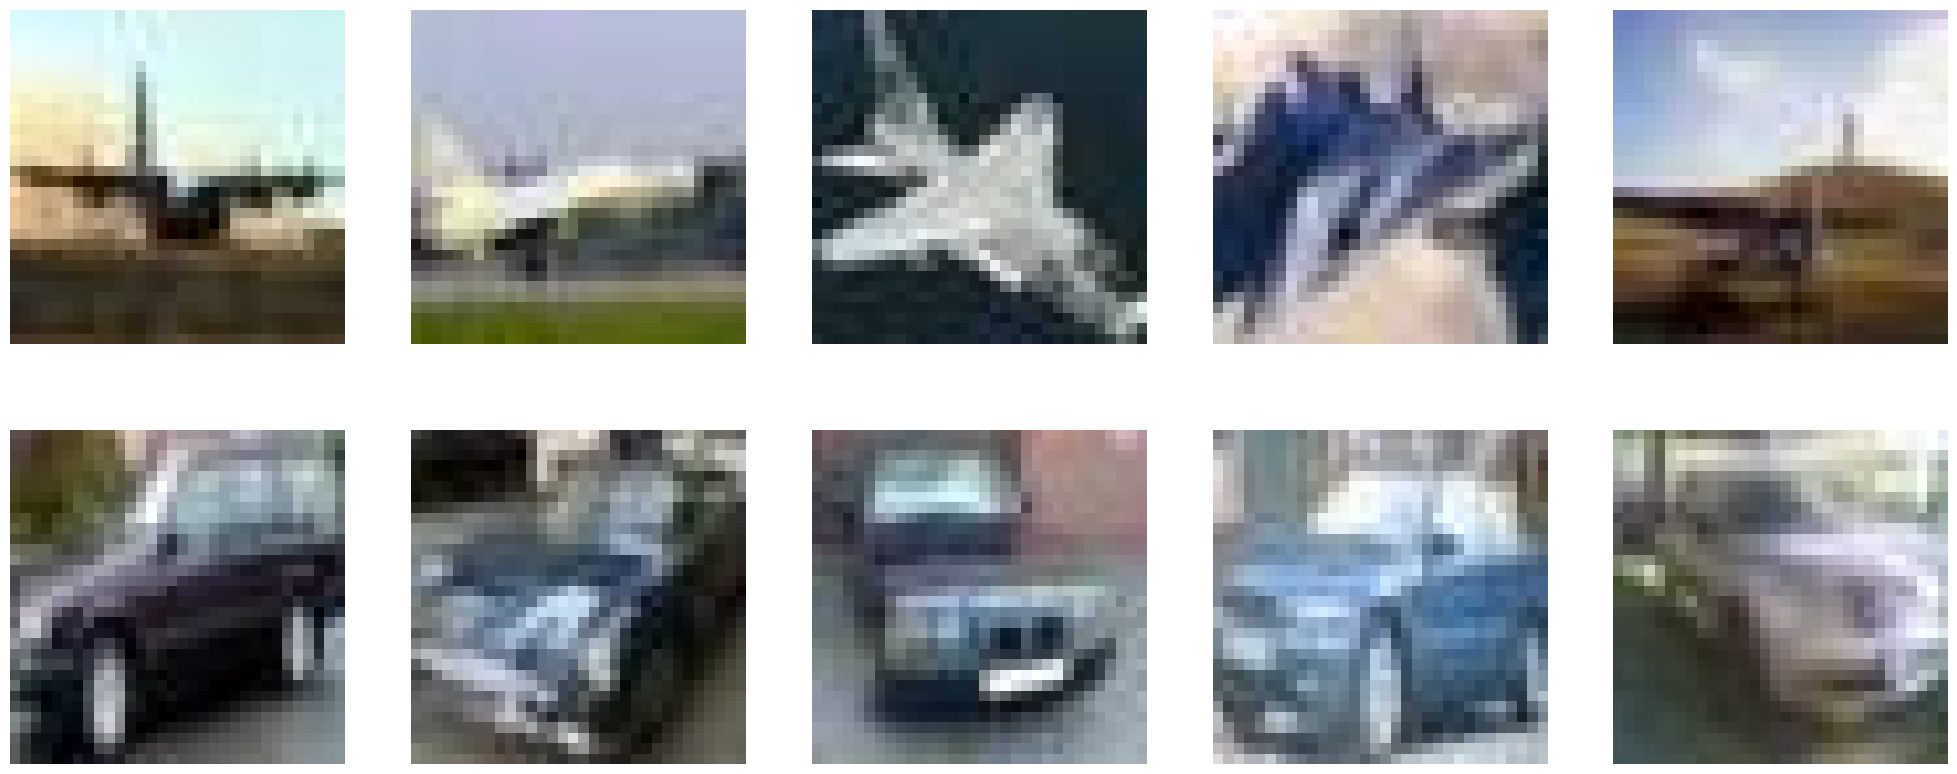

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(25, 10), dpi=100)

for i in range(0, len(ax)):

    dir = train_airplnae_dir if i == 0 else train_car_dir
    files = os.listdir(dir)

    for j in range(0, len(ax[i])):
        file_path = os.path.join(dir, files[j])
        sample = Image.open(file_path)
        ax[i][j].imshow(sample)
        ax[i][j].axis('off')

plt.show()
plt.close()

### 3~5 강사님.ver

#### 데이터셋의 파일 경로

In [8]:
train_dir = os.path.join(extract_dir, "train")
test_dir = os.path.join(extract_dir, "test")
print(train_dir)
print(test_dir)

/content/data/train
/content/data/test


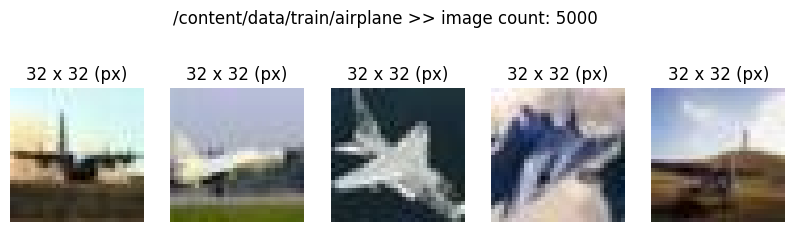

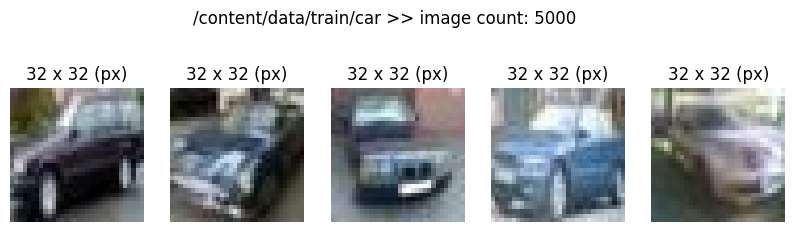

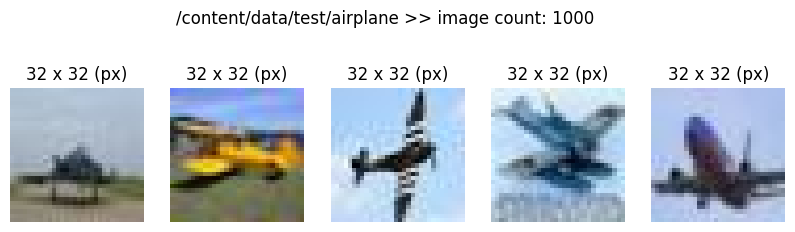

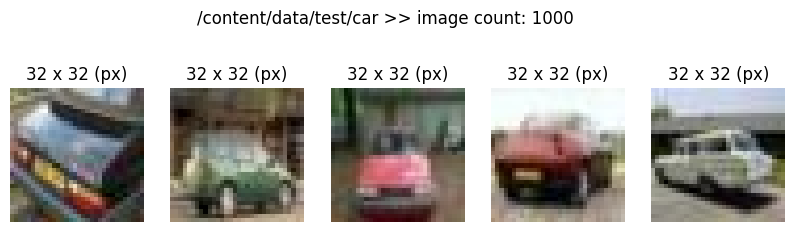

In [9]:
dirs = [train_dir, test_dir]
features = ['airplane', 'car']

for i, v in enumerate(dirs):
    for j, w in enumerate(features):
        target_dir = os.path.join(v, w)

        file_list = os.listdir(target_dir)
        file_count = len(file_list)

        fig, ax = plt.subplots(1, 5, figsize=(10, 3))
        fig.suptitle("%s >> image count: %d" % (target_dir, file_count))

        for k, x in enumerate(ax):
            file_path = os.path.join(target_dir, file_list[k])
            sample = Image.open(file_path)
            x.set_title("%d x %d (px)" % (sample.size[0], sample.size[1]), fontsize=12)
            x.imshow(sample)
            x.axis('off')

        plt.show()
        plt.close()

## #03. 데이터 전처리 (이미지 데이터 증강)

훈련 및 검증용 이미지가 저장되어 있는 폴더는 구분하고자 하는 종속변수의 수 만큼 하위 폴더를 갖는다.

> 비행기, 자동차로 이진 분류를 해야 하는 경우 2개의 하위 폴더가 필요하다는 의미(airplane, car)

`ImageDataGenerator`는 훈련용 이미지가 저장되어 있는 폴더, 검증용 이미지가 저장되어 있는 폴더까지만 전달한다.

`ImageDataGenerator`가 하위 폴더를 식별하여 그 안의 `airplane`, `car` 폴더 안의 항목들을 읽어들인다.

> batch_size가 클 수록 학습 속도는 빨라지지만 정확도는 하락.

| 파라미터 | 설명 |
|---|---|
| rescale | 색상에 대한 정규화 처리 |
| rotation_range | 지정된 각도 범위내에서 임의로 원본 이미지를 회전 시킴 |
| width_shift_range | 지정된 값 내에서 임의로 원본 이미지를 수평 이동 시킴 |
| height_shift_range | 지정된 값 내에서 임의로 원본 이미지를 수직 이동 시킴 |
| vertical_flip | `True`인 경우 이미지를 수직 반전 시킴 |
| horizontal_flip | `True`인 경우 이미지를 수평 반전 시킴 |
| validation_split | 훈련용, 검증용을 분할하고자 할 경우 검증용의 비율을 지정 |

In [10]:
train_datagen = ImageDataGenerator(rescale = 1.0/255) #일반화
test_datagen = ImageDataGenerator(rescale = 1.0/255) #일반화

# train 이미지 데이터 증강
train_set = train_datagen.flow_from_directory(train_dir, classes=['airplane', 'car'],
                                              batch_size=20,    # 이미지를 증강시킬 배수
                                              class_mode='binary',      # 이진분류용임을 명시
                                              target_size=(32, 32)   # 변환될 이미지 해상도(크기)
                                              )

# test 이미지 데이터 증강
test_set = test_datagen.flow_from_directory(test_dir, classes=['airplane', 'car'],
                                            batch_size=20,  # 이미지를 증강시킬 배수
                                            class_mode='binary',    # 이진분류용임을 명시
                                            target_size=(32, 32)    # 변환될 이미지 해상도(크기)
                                            )

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## #04. 모델개발

### 모델 정의

(`Conv2D 적용 [-> BatchNormalization층 적용] -> MaxPool2D 적용 [-> Dropout]`)의 과정을 n번 반복 -> Flatten 레이어 추가 -> Dense층 n개 추가

- **Conv2D 층**
    - 영상이나 이미지의 특징을 확인하기 위한 함수
    - `filters`: 필터(커널)의 개수
    - `kernel_size`: 필터의 크기
    - `strides`: 필터의 이동 간격
    - `padding`: valid(패딩 없음), same(인풋과 아웃풋이 같도록 패딩)
    - `activation`: 활성화 함수
    - `input_shape`: 첫 레이어에 인풋으로 들어오는 크기
- **BatchNormalization (배치정규화)**
    - 신경망 입력데이터를 평균 0, 분산 1로 정규화해서 학습이 잘 이루어지도록 하는 방법
    - BatchNormalization 층에서 정규화를 수행하므로 별도의 정규화를 적용할 필요가 없다.
    - 만약 이 층을 적용하지 않는다면 학습 전에 별도의 정규화를 수행하는 것이 좋다.
- **MaxPool2D**
    - 컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만든다.
    - `pool_size`: 축소시킬 필터의 크기(비율)
    - `strides`: 필터의 이동 간격. 기본값으로 pool_size를 갖는다.
    - 일반적으로 strides는 pool_size와 동일하게 적용되므로 생략하는 편.


 > filter가 클수록, kernel_size가 작을 수록 모델이 성능이 개선됨.
 단, 학습 시간도 오래 걸림.

> activation : 다중분류 = softmax, unit 10 / 이진 = sigmoid, unit 1/0

> loss : 다중분류 = categorical_crossentropy, 이진 = binary_crossentropy

In [11]:
model = Sequential()

# ------------------------#
# 1차
# ------------------------#
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32,32,3)))   #컬러 이미지는 3차원
model.add(BatchNormalization()) #배치정규화
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# ------------------------#
# 2차
# ------------------------#
model.add(Conv2D(filters=64, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))   #컬러 이미지는 3차원
model.add(BatchNormalization()) #배치정규화
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 가위바위보면
# model.add(Dense(3, activation='softmax')), 아래 loss = 'categorical_crossentropy'

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        8256      
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        2

### 학습하기

- epochs는 많아도 크게 상관이 없음(단, 너무 크면 오래 걸리고 오차가 증가)
    - callback을 사용해 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링
    - EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ReduceLROnPlateau EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ModelCheckpoint 지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

In [12]:
# %%time
# result = model.fit(train_set, epochs=500, validation_data=test_set, callbacks = [
#     EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
#     ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
# ])

start = dt.datetime.now()

result = model.fit(train_set, epochs=500, validation_data=test_set, callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

end = dt.datetime.now()

delta = end - start

"총 학습 소요 시간: %d(초)" % delta.seconds

Epoch 1/500
500/500 [==============================] - 19s 13ms/step - loss: 0.3780 - acc: 0.8616 - val_loss: 0.4929 - val_acc: 0.8430 - lr: 0.0010
Epoch 2/500
500/500 [==============================] - 8s 15ms/step - loss: 0.2032 - acc: 0.9170 - val_loss: 0.1723 - val_acc: 0.9255 - lr: 0.0010
Epoch 3/500
500/500 [==============================] - 6s 13ms/step - loss: 0.1573 - acc: 0.9369 - val_loss: 0.1743 - val_acc: 0.9335 - lr: 0.0010
Epoch 4/500
500/500 [==============================] - 7s 15ms/step - loss: 0.1273 - acc: 0.9518 - val_loss: 0.1786 - val_acc: 0.9225 - lr: 0.0010
Epoch 5/500
500/500 [==============================] - 6s 13ms/step - loss: 0.1116 - acc: 0.9570 - val_loss: 0.1549 - val_acc: 0.9395 - lr: 0.0010
Epoch 6/500
500/500 [==============================] - 6s 12ms/step - loss: 0.0868 - acc: 0.9674 - val_loss: 0.1560 - val_acc: 0.9495 - lr: 0.0010
Epoch 7/500
500/500 [==============================] - 7s 15ms/step - loss: 0.0692 - acc: 0.9756 - val_loss: 0.2254 -

'총 학습 소요 시간: 87(초)'

## #05. 학습 결과 평가

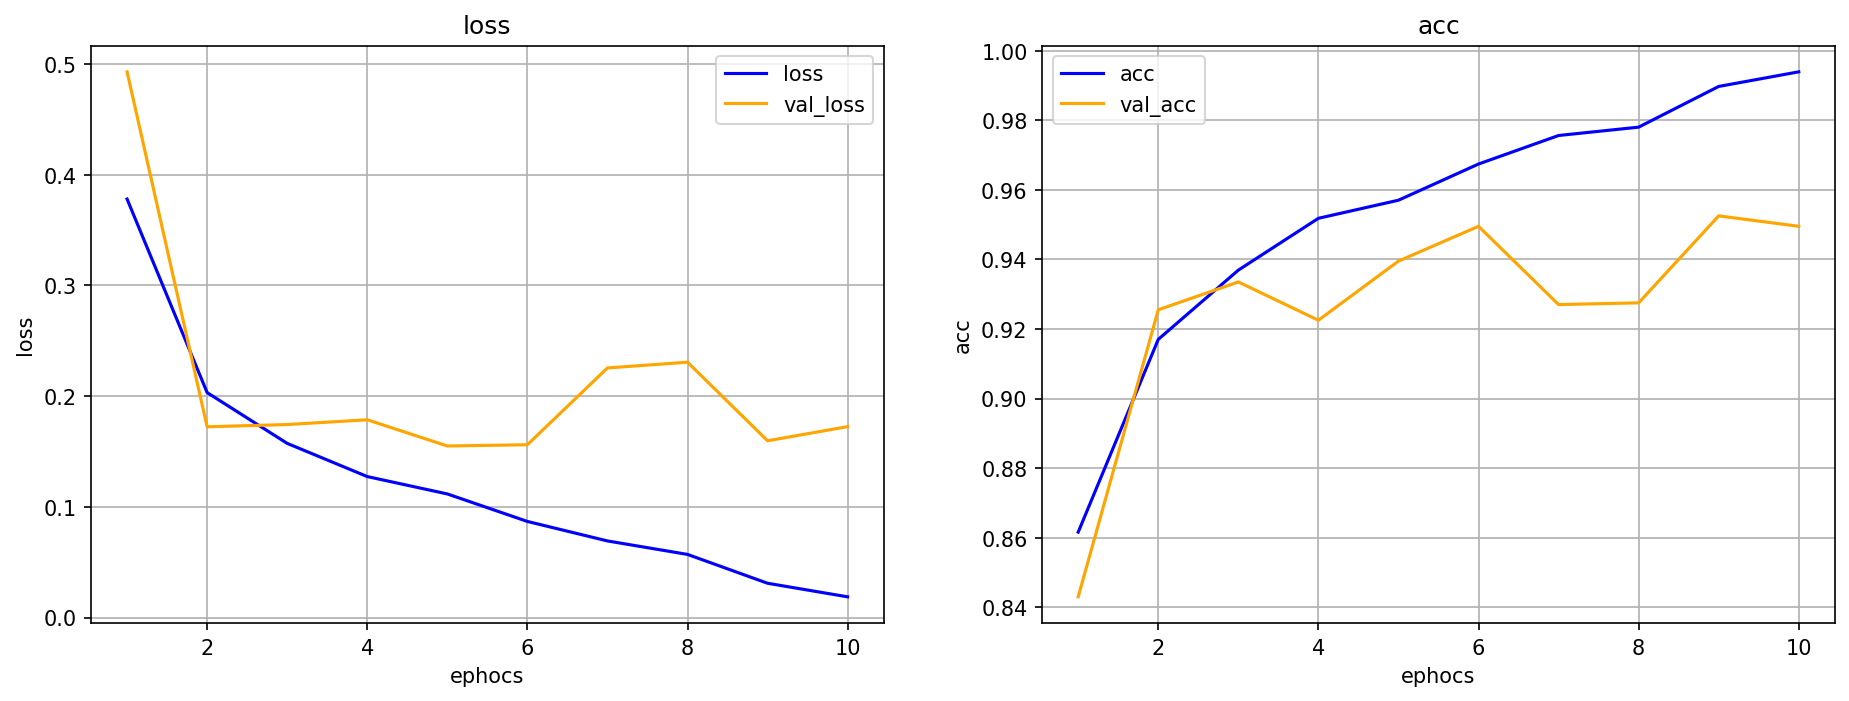

In [14]:
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)

# 학습 결과 그래프의 컬럼 명
column_names = result_df.columns

# 학습데이터에 대한 필드이름
train_column_name = [column_names[0], column_names[1]]

# 검증데이터에 대한 필드이름
test_column_name = [column_names[2], column_names[3]]

# 학습 결과 그래프

# # 그래프 객체 생성
fig, ax = plt.subplots(1,2, figsize=(15, 5), dpi=150)

# # 훈련 및 검증 데이터의 손실률, 절대오차 그래프 그리기
for i, v in enumerate(ax):
    sb.lineplot(x=result_df.index, y=train_column_name[i], data=result_df, color='blue', label=train_column_name[i], ax=v)
    sb.lineplot(x=result_df.index, y=test_column_name[i], data=result_df, color='orange', label=test_column_name[i], ax=v)
    v.set_title(train_column_name[i])
    v.set_xlabel('ephocs')
    v.set_ylabel(train_column_name[i])
    v.grid()
    v.legend()

plt.show()
plt.close()

In [15]:
# helper_colab.tf_result_plot(result)

evaluate1 = model.evaluate(train_set)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(test_set)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

500/500 [==============================] - 5s 10ms/step - loss: 0.0070 - acc: 0.9980
최종 훈련 손실률: 0.006976, 최종 훈련 정확도: 0.998000
100/100 [==============================] - 1s 9ms/step - loss: 0.1724 - acc: 0.9495
최종 검증 손실률: 0.172404, 최종 검증 정확도: 0.949500


## #06. 학습 결과 적용

### 1. 훈련 데이터에 대한 예측 결과를 산정

In [16]:
pred = model.predict(train_set)
data_count, case_count = pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
pred

500/500 [==============================] - 5s 10ms/step
10000개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[1.0455688e-08],
       [4.2238121e-06],
       [1.0000000e+00],
       ...,
       [2.5444347e-04],
       [4.0338746e-06],
       [1.8551853e-05]], dtype=float32)

### 2. 예측 결과(확률)를 반올림하여 예측치 생성

In [17]:
pred_result = np.round(pred)
pred_result = pred_result.flatten()
pred_result

array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)

### 3. 실제 이미지, 레이블, 예측치 확인

In [18]:
# 각 종속변수별로 레이블링이 어떻게 되어 있는 확인
train_set.class_indices

{'airplane': 0, 'car': 1}

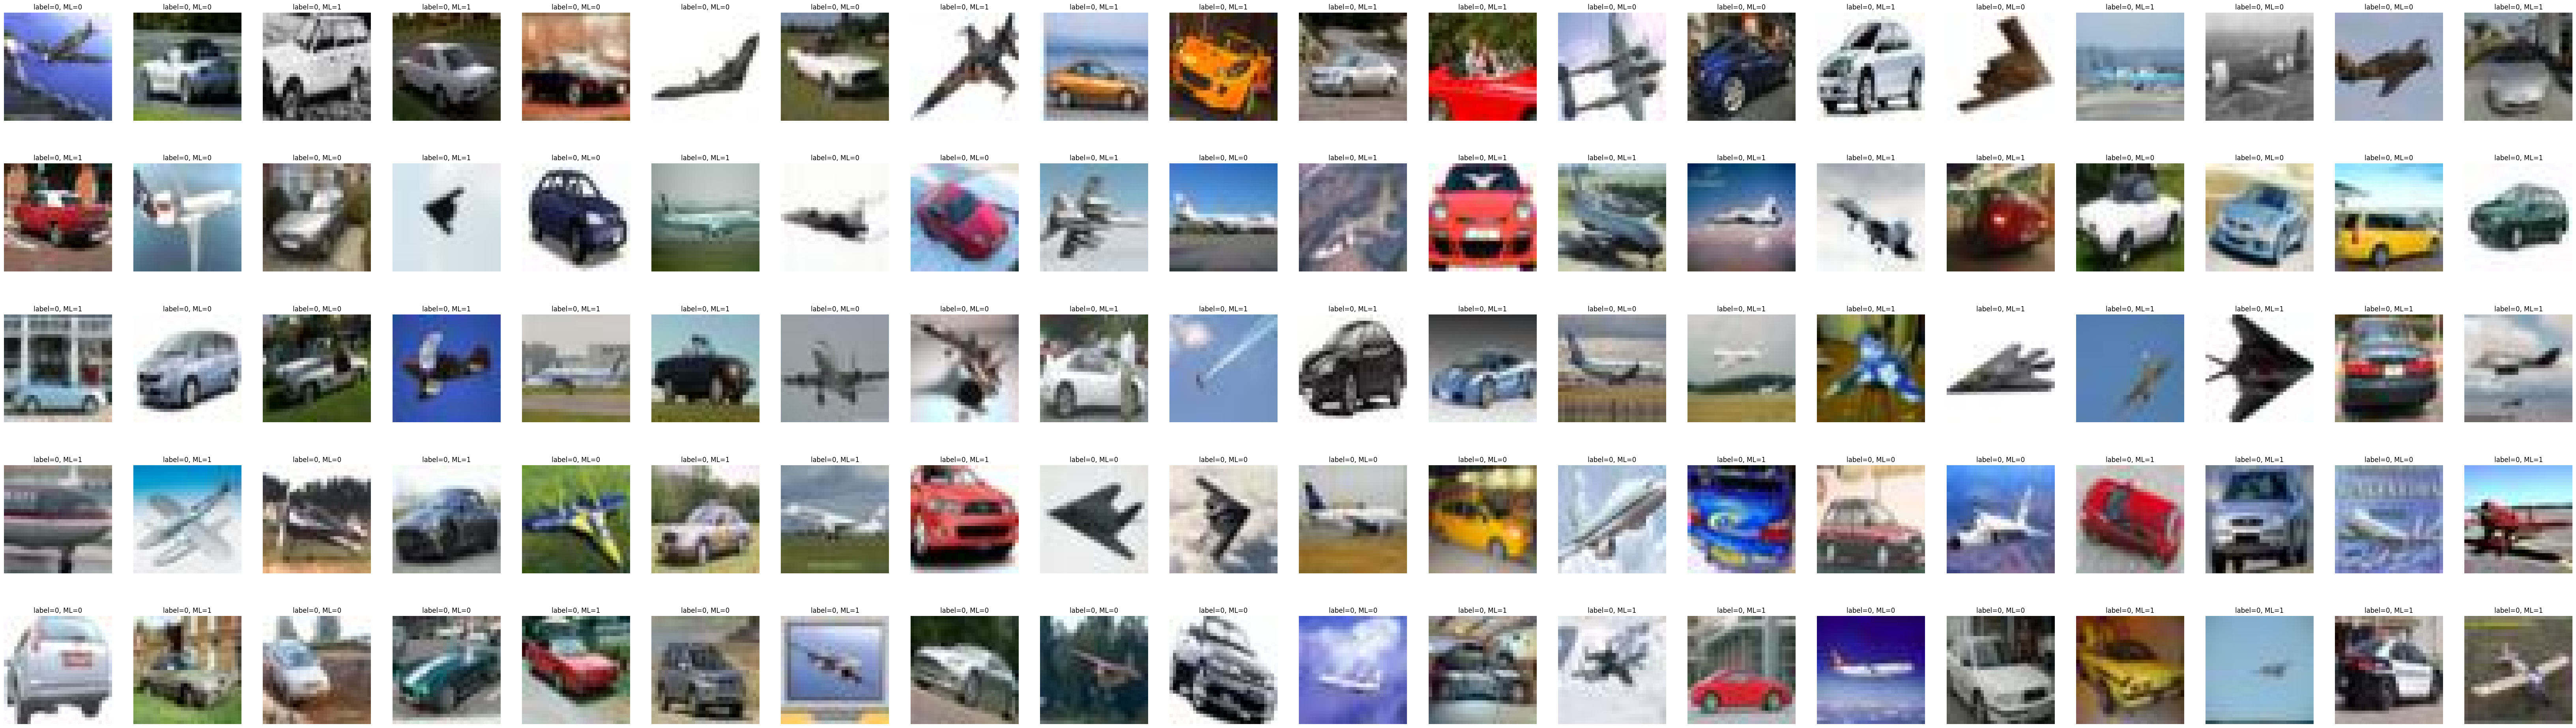

In [21]:
row = 5                     # 내가 몇 줄을 출력하고 싶은지 지정
col = train_set.batch_size  # batch-size에 맞춰서 지정 (값이 너무 클 경우 반복문 로직을 따로 적용)
fig, ax = plt.subplots(row, col, figsize=((col+1)*4, (row+1)*4), dpi=100)

k = 0

for i in range(0, row):
    # batch_size 만큼의 첫 번째 이미지 묶음을 반환
    # -> img와 label의 길이는 col과 동일하다.
    img, label = train_set.next()

    for j in range(0, col):
        # 종속변수인 label은 one-hot-encoding 형태로 반환되므로 몇 번째 인덱스가 `1`인지 찾아야 한다.
        label_max = np.argmax(label[j], axis=-1)

        ax[i][j].imshow(img[j])
        ax[i][j].set_title("label=%d, ML=%d" % (label_max, pred_result[k]))
        ax[i][j].axis('off')
        k += 1

plt.show()
plt.close()

### 4. 혼동행렬

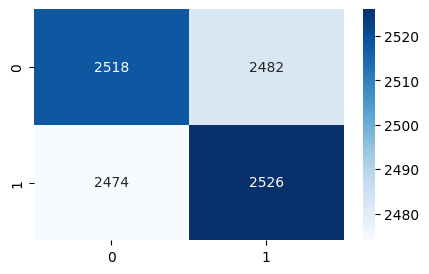

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_set.labels, pred_result)
cmdf = DataFrame(cm)

plt.figure(figsize=(5, 3))
sb.heatmap(cmdf, annot = True, fmt = 'd', cmap = 'Blues')
plt.show()
plt.close()
